# Regression Transformer

## Import libraries

In [1]:
# Data packages
import os
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# Math
import math
# Pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
# Import weights & Biases
import wandb

In [2]:
# Set up weights & Biases
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: kurtwal98 (kurtwal98-university-of-california-berkeley). Use `wandb login --relogin` to force relogin


True

In [3]:
# Print torch version
print(f"PyTorch version: {torch.__version__}")

# Print device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")

PyTorch version: 2.4.1+cu121
Device: cuda


## Data Loading

In [4]:
path = r'TF_HLC'

In [5]:
# Load data
freq_data = np.genfromtxt(os.path.join(path,"TTF_freq_200.csv"), delimiter=",")

# Load pickle
with open(os.path.join(path,"TTF_data_200.pt"), "rb") as f:
    TTF_data = pickle.load(f)

with open(os.path.join(path,"Vs_values_200.pt"), "rb") as f:
    Vs_data = pickle.load(f)

TTF_data = np.array(TTF_data)
Vs_data = np.array(Vs_data)

print(TTF_data.shape, Vs_data.shape,freq_data.shape)

# Convert freq_data to 1000,2000 vector
#freq_vals = np.repeat(np.expand_dims(freq_data, axis=0), 1000, axis=0)
freq_vals = freq_data
print(freq_vals.shape)


(1000, 200) (1000, 29) (200,)
(200,)


In [6]:
class TTF_dataset(Dataset):
    def __init__(self, TTF_values, Vs_values):
        self.TTF_values = TTF_values
        self.Vs_values = Vs_values
        
    def __len__(self):
        return len(self.TTF_values)
    
    def __getitem__(self, idx):
        # Target data
        target_data = self.TTF_values[idx]
        target_data = torch.tensor(target_data, dtype=torch.float32).unsqueeze(1)
        # Input data
        input_data = torch.tensor(self.Vs_values[idx], dtype=torch.float32)
        input_data = torch.nan_to_num(input_data, nan=0.0, posinf=0.0, neginf=0.0).unsqueeze(1)

        return input_data, target_data

In [7]:
dataset = TTF_dataset(TTF_data, Vs_data)
print("Dataset done!")
print("Dataset length: ", len(dataset))
print("Dataset shape: ", dataset[0][0].shape, dataset[0][1].shape)

Dataset done!
Dataset length:  1000
Dataset shape:  torch.Size([29, 1]) torch.Size([200, 1])


In [8]:
# Separate into training and testing
train_size = int(0.7 * len(dataset))
val_size = (len(dataset) - train_size) // 2
test_size = len(dataset) - train_size - val_size
print("Train, validation and test sizes: " , train_size, val_size, test_size)

train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
print("Number of batches: ", len(train_loader), len(val_loader), len(test_loader))
print("Training shapes: ", next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape)

Train, validation and test sizes:  700 150 150
Number of batches:  14 3 3
Training shapes:  torch.Size([50, 29, 1]) torch.Size([50, 200, 1])


## Regression Transformer

In [9]:
# Positional encoding
class PositionalEncoding(nn.Module):
    def __init__(self, model_dim, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, model_dim)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, model_dim, 2).float() * (-math.log(10000.0) / model_dim))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

In [10]:
class RegressionTransformer(nn.Module):
    def __init__(self, input_dim, model_dim, num_heads, num_layers, output_dim, target_seq_len, dropout=0.1):
        super(RegressionTransformer, self).__init__()
        self.model_dim = model_dim
        self.embedding = nn.Linear(input_dim, model_dim)
        self.pos_encoder = PositionalEncoding(model_dim, dropout)
        encoder_layers = nn.TransformerEncoderLayer(model_dim, num_heads, model_dim * 2, dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        self.decoder = nn.Linear(model_dim, output_dim)
        self.upsample = nn.Upsample(size=target_seq_len, mode='linear')
        
    def forward(self, src):
        src = self.embedding(src) * math.sqrt(self.model_dim)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src)
        
        # Reshape for upsampling
        output = output.permute(0, 2, 1)  # (batch_size, model_dim, sequence_length)
        output = self.upsample(output)  # Upsample to (batch_size, model_dim, target_seq_len)
        output = output.permute(0, 2, 1)  # (batch_size, target_seq_len, model_dim)
        
        output = self.decoder(output)
        return output

In [11]:
# Example usage
input_dim = 1
model_dim = 64
num_heads = 8
num_layers = 6
output_dim = 1  # Desired output dimension
target_seq_len = 200  # Desired sequence length
dropout = 0.1

model = RegressionTransformer(input_dim, model_dim, num_heads, num_layers, output_dim, target_seq_len, dropout)
src = torch.randn(50, 29, input_dim)  # Example input
output = model(src)
print(output.shape) 

torch.Size([50, 200, 1])


## Training

In [12]:
from training import EarlyStopping, train_model, test_model

In [13]:
# Define yaml for model configuration
config = {
    "input_dim": 1,
    "model_dim": 10,
    "num_heads": 2,
    "num_layers": 6,
    "output_dim": 1,
    "target_seq_len": 200,
    "dropout": 0.1,
    "batch_size": 50,
    "lr": 5e-3,
    "num_epochs": 1000,
    "patience_scheduler": 100,
    "patience_stopping": 100,
    "loss": "L1"
}

In [14]:
# Define model
model = RegressionTransformer(config["input_dim"], 
                              config["model_dim"], 
                              config["num_heads"], 
                              config["num_layers"], 
                              config["output_dim"], 
                              config["target_seq_len"], 
                              config["dropout"])

In [15]:
# Define batch size and data loaders
batch_size = config["batch_size"]
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [16]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=config["lr"])

# Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', 
factor=0.5, 
patience=config["patience_scheduler"], threshold_mode='rel', 
cooldown=0, min_lr=1e-5, eps=1e-08)

# Training
num_epochs = config["num_epochs"]

# Loss
loss_fn = nn.L1Loss()


In [17]:
train_losses, val_losses, model =  train_model(model, optimizer, scheduler, train_loader, val_loader, loss_fn, 
epochs=config["num_epochs"]
, device=device, patience=config["patience_stopping"]
, clipping=True, print_epoch=20)

Training:   0%|          | 0/1000 [00:00<?, ?epoch/s]c:\Users\kurt-\miniconda3\envs\ML\Lib\site-packages\torch\nn\functional.py:5560: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = scaled_dot_product_attention(q, k, v, attn_mask, dropout_p, is_causal)
Training:   0%|          | 1/1000 [00:00<10:40,  1.56epoch/s]

 Epoch 0, Train Loss: 1.6333820564406258, Val Loss: 1.6703431208928425, LR: 0.005


Training:   1%|          | 11/1000 [00:03<04:40,  3.52epoch/s]                                    

 Epoch 10, Train Loss: 1.4912167957850866, Val Loss: 1.628377874692281, LR: 0.005


Training:   2%|▏         | 21/1000 [00:06<04:42,  3.47epoch/s, EarlyStopping counter: 1 out of 100]

 Epoch 20, Train Loss: 1.4605039528438024, Val Loss: 1.5890953143437703, LR: 0.005


Training:   3%|▎         | 31/1000 [00:09<04:40,  3.45epoch/s]                                     

 Epoch 30, Train Loss: 1.4447516713823592, Val Loss: 1.5575480063756306, LR: 0.005


Training:   4%|▍         | 41/1000 [00:12<04:35,  3.48epoch/s, EarlyStopping counter: 7 out of 100]

 Epoch 40, Train Loss: 1.422558605670929, Val Loss: 1.6119091510772705, LR: 0.005


Training:   5%|▌         | 51/1000 [00:14<04:32,  3.48epoch/s, EarlyStopping counter: 9 out of 100]

 Epoch 50, Train Loss: 1.4161901133401054, Val Loss: 1.5517254273096721, LR: 0.005


Training:   6%|▌         | 61/1000 [00:17<04:29,  3.48epoch/s, EarlyStopping counter: 3 out of 100] 

 Epoch 60, Train Loss: 1.4059388041496277, Val Loss: 1.579529603322347, LR: 0.005


Training:   7%|▋         | 71/1000 [00:20<04:26,  3.49epoch/s, EarlyStopping counter: 1 out of 100] 

 Epoch 70, Train Loss: 1.4295987742287772, Val Loss: 1.5815817912419636, LR: 0.005


Training:   8%|▊         | 81/1000 [00:23<04:17,  3.57epoch/s, EarlyStopping counter: 11 out of 100]

 Epoch 80, Train Loss: 1.404235942023141, Val Loss: 1.535932461420695, LR: 0.005


Training:   9%|▉         | 91/1000 [00:26<04:14,  3.57epoch/s, EarlyStopping counter: 21 out of 100]

 Epoch 90, Train Loss: 1.4239670549120222, Val Loss: 1.5527594884236653, LR: 0.005


Training:  10%|█         | 101/1000 [00:29<04:17,  3.49epoch/s, EarlyStopping counter: 31 out of 100]

 Epoch 100, Train Loss: 1.40895847763334, Val Loss: 1.5560600757598877, LR: 0.005


Training:  11%|█         | 111/1000 [00:32<04:11,  3.53epoch/s, EarlyStopping counter: 41 out of 100]

 Epoch 110, Train Loss: 1.412170103618077, Val Loss: 1.563038428624471, LR: 0.005


Training:  12%|█▏        | 121/1000 [00:34<04:07,  3.55epoch/s, EarlyStopping counter: 51 out of 100]

 Epoch 120, Train Loss: 1.40129987682615, Val Loss: 1.5598754088083904, LR: 0.005


Training:  13%|█▎        | 131/1000 [00:37<04:11,  3.46epoch/s, EarlyStopping counter: 61 out of 100]

 Epoch 130, Train Loss: 1.4084209884916032, Val Loss: 1.6322492758433025, LR: 0.005


Training:  14%|█▍        | 141/1000 [00:40<04:04,  3.51epoch/s, EarlyStopping counter: 71 out of 100]

 Epoch 140, Train Loss: 1.4031916516167777, Val Loss: 1.559305747350057, LR: 0.005


Training:  15%|█▌        | 151/1000 [00:43<04:04,  3.47epoch/s, EarlyStopping counter: 81 out of 100]

 Epoch 150, Train Loss: 1.3984631640570504, Val Loss: 1.5729507605234783, LR: 0.005


Training:  16%|█▌        | 161/1000 [00:46<04:14,  3.29epoch/s, EarlyStopping counter: 7 out of 100] 

 Epoch 160, Train Loss: 1.4032121896743774, Val Loss: 1.5654367208480835, LR: 0.005


Training:  17%|█▋        | 171/1000 [00:49<03:54,  3.54epoch/s, EarlyStopping counter: 17 out of 100]

 Epoch 170, Train Loss: 1.4044374568121774, Val Loss: 1.5755587021509807, LR: 0.005


Training:  18%|█▊        | 181/1000 [00:53<04:43,  2.89epoch/s, EarlyStopping counter: 27 out of 100]

 Epoch 180, Train Loss: 1.4065329006740026, Val Loss: 1.5872517029444377, LR: 0.005


Training:  19%|█▉        | 191/1000 [00:56<04:01,  3.36epoch/s, EarlyStopping counter: 37 out of 100]

 Epoch 190, Train Loss: 1.3935081277574812, Val Loss: 1.5628401041030884, LR: 0.005


Training:  20%|██        | 201/1000 [00:59<03:55,  3.39epoch/s, EarlyStopping counter: 47 out of 100]

 Epoch 200, Train Loss: 1.3972844736916679, Val Loss: 1.5559966564178467, LR: 0.005


Training:  21%|██        | 211/1000 [01:02<04:09,  3.16epoch/s, EarlyStopping counter: 57 out of 100]

 Epoch 210, Train Loss: 1.4023596899850028, Val Loss: 1.6038155158360798, LR: 0.005


Training:  22%|██▏       | 221/1000 [01:05<03:55,  3.31epoch/s, EarlyStopping counter: 67 out of 100]

 Epoch 220, Train Loss: 1.397846988269261, Val Loss: 1.6112764279047649, LR: 0.005


Training:  23%|██▎       | 231/1000 [01:08<04:15,  3.01epoch/s, EarlyStopping counter: 77 out of 100]

 Epoch 230, Train Loss: 1.4027576787131173, Val Loss: 1.535644809405009, LR: 0.005


Training:  24%|██▍       | 241/1000 [01:11<03:51,  3.28epoch/s, EarlyStopping counter: 87 out of 100]

 Epoch 240, Train Loss: 1.3917789544378008, Val Loss: 1.5817497968673706, LR: 0.005


Training:  25%|██▌       | 251/1000 [01:14<03:35,  3.48epoch/s, EarlyStopping counter: 97 out of 100]

 Epoch 250, Train Loss: 1.394007044179099, Val Loss: 1.5571290254592896, LR: 0.005


Training:  25%|██▌       | 253/1000 [01:15<03:42,  3.36epoch/s, EarlyStopping counter: 100 out of 100]

Early stopping


Text(0.5, 1.0, 'Losses')

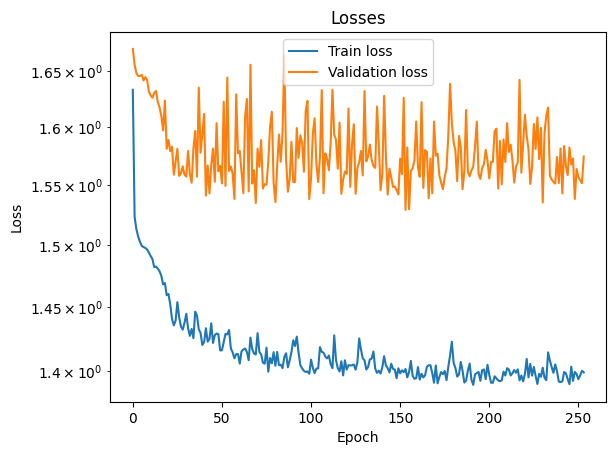

In [18]:
# Plot losses
sns.lineplot(x=range(len(train_losses)), y=train_losses, label="Train loss")
sns.lineplot(x=range(len(val_losses)), y=val_losses, label="Validation loss")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Losses")

In [19]:
# Test model
test_loss, target, predictions = test_model(model, test_loader, loss_fn, device=device)
print(f"Test loss: {test_loss}")

Test loss: 1.37932554880778


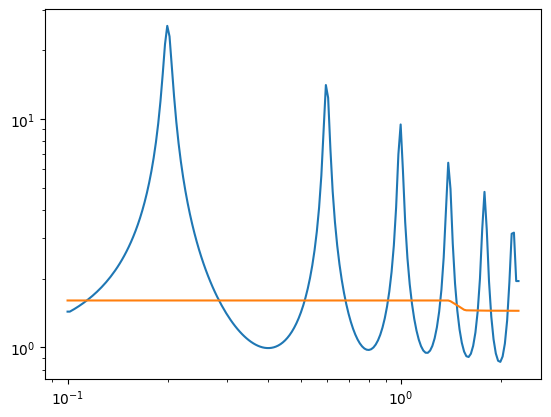

In [27]:
plt.loglog(freq_vals, target[0])
plt.loglog(freq_vals, predictions[0])